<a href="https://colab.research.google.com/github/sdannels/synthetic_time_series_forecasting/blob/main/synthetic_forecasts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torch numpy pandas matplotlib scikit-learn fredapi statsmodels datetime keras math

In [2]:
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import datetime as dt
import torch
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
#from gretel_synthetics.timeseries_dgan.dgan import DGAN
#from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [3]:
# read in economic data and convert to DateTime index
df = pd.read_csv("/content/drive/MyDrive/Synthetic_data/fred_data", index_col = 0)
df.index = pd.DatetimeIndex(df.index)
df.index.name = 'date'
df = df.reset_index()
# create lag of 10-year yield
df['DGS10_lag'] = df['DGS10'].shift(1)

# Autoregressive Model

In [4]:
# set last date for training data and first date for forecasting (next day)
last_train_date = '12-31-2016'
start_forecast_date = dt.datetime.strptime(last_train_date, '%m-%d-%Y') + dt.timedelta(days = 3)
start_forecast_date = start_forecast_date.strftime('%m-%d-%Y')
end_forecast_date = '12-31-2019'

# split up training and testing data
train_df = df[df['date'] <= last_train_date]
test_df = df[df['date'] > last_train_date]

In [5]:
# choose optimal number of lags by BIC
opt_mod = ar_select_order(train_df['DGS1'], exog = train_df['DGS10_lag'], 
                          maxlag=15, ic = 'bic', missing = 'drop', old_names = False)
print(f'Chosen lags: {opt_mod.ar_lags}')
# fit model with chosen number of lags and heteroskedastic-robust standard errors
mod = AutoReg(train_df['DGS1'], exog = train_df['DGS10_lag'], lags = 13, trend = 'c',
              missing = 'drop', old_names = False)
res = mod.fit(cov_type="HC0")
print(res.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


Chosen lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]
                            AutoReg Model Results                             
Dep. Variable:                   DGS1   No. Observations:                13734
Model:                  AutoReg-X(13)   Log Likelihood               14775.944
Method:               Conditional MLE   S.D. of innovations              0.082
Date:                Mon, 16 Jan 2023   AIC                             -4.989
Time:                        02:42:52   BIC                             -4.981
Sample:                            13   HQIC                            -4.986
                                13734                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.002      0.325      0.745      -0.004       0.005
DGS1.L1        1.1031      0.021     51.607      0.000       1.061       1.14

In [6]:
# find start and end index numbers
df_index = df.copy()
start_forecast_index = df_index.index[df_index['date'] == start_forecast_date][0]
end_forecast_index = df_index.index[df_index['date'] == end_forecast_date][0]
del df_index

# forecast
ar_preds = res.predict(start = start_forecast_index, end = end_forecast_index, 
                       exog_oos = test_df['DGS10_lag'], dynamic = False)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


RMSE: 0.5843206747512005
MAPE: 21.987263125616693


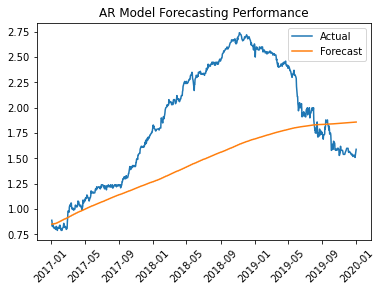

In [7]:
# compare forecasts to actuals
actuals = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), 'DGS1']
actuals_df = df.loc[(df['date'] >= start_forecast_date) & (df['date'] <= end_forecast_date), ['date', 'DGS1']]
ar_compare = pd.concat([actuals_df, ar_preds], axis = 1)
ar_compare.columns = ['date', 'actual', 'forecast']

# compute RMSE and MAPE
ar_rmse = math.sqrt(mean_squared_error(actuals, ar_preds))
ar_mape = mean_absolute_percentage_error(actuals, ar_preds)*100
print(f'RMSE: {ar_rmse}')
print(f'MAPE: {ar_mape}')

# plot results
plt.plot(ar_compare['date'], ar_compare['actual'], label = 'Actual')
plt.plot(ar_compare['date'], ar_compare['forecast'], label = 'Forecast')
plt.title('AR Model Forecasting Performance')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

# LSTM Neural Network (Real Data)

Parts of code adapted from examples in: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [8]:
# function to reformat data from df to numpy array
def df_to_np(df, cols):
  """
    df: pandas DataFrame
    cols = list of column names from df to include
  """
  data = df[cols]
  data = data.to_numpy()
  return data

# function to split data into samples for NN
def split_NN_samples(data, n_steps):
  X, y = list(), list()
  for i in range(len(data)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(data)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [9]:
# select features from df and # of steps for each sample
feature_cols = ['DGS1', 'DGS10']
n_steps = 25

# format training data
train_data = df_to_np(train_df, feature_cols)
train_x, train_y = split_NN_samples(data = train_data, n_steps = n_steps)
# train_x shape is (# of samples, # of steps, # of features)
print(train_x.shape)
n_features = train_x.shape[2]
# train_y shape is (# of samples, # of features)
print(train_y.shape)

(13710, 25, 2)
(13710, 2)


In [15]:
# define model
LSTM_model = Sequential()
LSTM_model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_model.add(LSTM(100, activation='tanh'))
LSTM_model.add(Dense(n_features))
LSTM_model.compile(optimizer='adam', loss='mse')

In [16]:
# if true, load a pretrained model instead of training
load_pretrain = True

if load_pretrain == True:
  LSTM_model = keras.models.load_model("/content/drive/MyDrive/Synthetic_data/LSTM_model")
else:
  # train model
  LSTM_model.fit(train_x, train_y, epochs = 200, verbose = 0)

In [ ]:
# save model after training
LSTM_model.save("/content/drive/MyDrive/Synthetic_data/LSTM_model")

In [10]:
# format test data
test_df = df[(df['date'] > last_train_date) & (df['date'] <= end_forecast_date)]
test_data = df_to_np(test_df, feature_cols)
test_x, test_y = split_NN_samples(data = test_data, n_steps = n_steps)
# test_x shape is (# of samples, # of steps, # of features)
print(test_x.shape)
# test_y shape is (# of samples, # of features)
print(test_y.shape)

(724, 25, 2)
(724, 2)


In [18]:
# forecast on test data
yhat = LSTM_model.predict(test_x, verbose=0)

RMSE: 0.11051287081831773
MAPE: 4.494627667379585


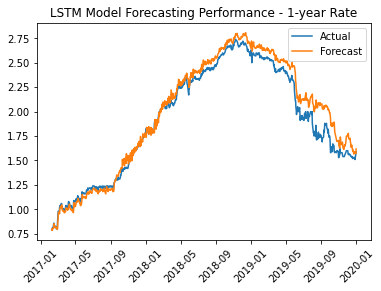

In [19]:
# format dates for comparison
date_compare = test_df['date'].reset_index(drop = True)
date_compare = date_compare[n_steps:].reset_index(drop = True)

# create dataframe for comparing forecasts to actual
LSTM_compare = pd.concat([pd.DataFrame(yhat), pd.DataFrame(test_y)], axis = 1)
LSTM_compare = pd.concat([date_compare, LSTM_compare], axis = 1)
LSTM_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# compute RMSE and MAPE for DGS1
LSTM_rmse = math.sqrt(mean_squared_error(LSTM_compare['DGS1_actual'], LSTM_compare['DGS1_pred']))
LSTM_mape = mean_absolute_percentage_error(LSTM_compare['DGS1_actual'], LSTM_compare['DGS1_pred'])*100
print(f'RMSE: {LSTM_rmse}')
print(f'MAPE: {LSTM_mape}')

# plot results
plt.plot(LSTM_compare['date'], LSTM_compare['DGS1_actual'], label = 'Actual')
plt.plot(LSTM_compare['date'], LSTM_compare['DGS1_pred'], label = 'Forecast')
plt.title('LSTM Model Forecasting Performance - 1-year Rate')
plt.legend()
plt.xticks(rotation = 45)
plt.show()

# LSTM Neural Network (Synthetic Data)

This model is trained on synthetic data, but tested on the same real data as above.

In [17]:
# load previously trained model
#if torch.cuda.is_available() == True:
#  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained.pt')
#else:
#  model = DGAN.load('/content/drive/MyDrive/Models/DGAN_trained.pt', map_location = torch.device('cpu'))

# generate synthetic data in numpy array format
# synthetic_attributes, synthetic_features = model.generate_numpy(1000)

# load synthetic data from DGAN_generation notebook
synthetic_features = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_features_reshaped")
### WARNING: ENSURE THAT SHAPE OF DATA HAS NOT CHANGED IN DGAN_Generation NOTEBOOK ###############
synthetic_features = synthetic_features.reshape(1000, 125, 2)
synthetic_attributes = np.loadtxt("/content/drive/MyDrive/Synthetic_data/synthetic_attributes")
synthetic_attributes = synthetic_attributes.reshape(-1, 1)

In [23]:
# iterate through synthetic samples and split into training data
for i in range(synthetic_features.shape[0]):
  synth_train_x_iter, synth_train_y_iter = split_NN_samples(data = synthetic_features[i, :, :], n_steps = n_steps)
  # start with first sample and then append each array after that
  if i == 0:
    synth_train_x, synth_train_y = synth_train_x_iter, synth_train_y_iter
  else:
    synth_train_x = np.concatenate([synth_train_x, synth_train_x_iter], axis = 0)
    synth_train_y = np.concatenate([synth_train_y, synth_train_y_iter], axis = 0)

print(synth_train_x.shape)
print(synth_train_y.shape)

In [25]:
# define model (should be same as model used for real data)
LSTM_synth_model = Sequential()
LSTM_synth_model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_steps, n_features)))
LSTM_synth_model.add(LSTM(100, activation='tanh'))
LSTM_synth_model.add(Dense(n_features))
LSTM_synth_model.compile(optimizer='adam', loss='mse')

In [26]:
# if true, load a pretrained model instead of training
load_synth_pretrain = True

if load_synth_pretrain == True:
  LSTM_synth_model = keras.models.load_model("/content/drive/MyDrive/Synthetic_data/LSTM_synth_model")
else:
  # train model
  LSTM_synth_model.fit(synth_train_x, synth_train_y, epochs = 150, verbose = 0)

Epoch 1/200
3125/3125 [==============================] - 24s 5ms/step - loss: 0.2291
Epoch 2/200
3125/3125 [==============================] - 17s 5ms/step - loss: 0.0431
Epoch 3/200
3125/3125 [==============================] - 20s 7ms/step - loss: 0.0351
Epoch 4/200
3125/3125 [==============================] - 19s 6ms/step - loss: 0.0321
Epoch 5/200
3125/3125 [==============================] - 17s 6ms/step - loss: 0.0322
Epoch 6/200
3125/3125 [==============================] - 17s 6ms/step - loss: 0.0299
Epoch 7/200
3125/3125 [==============================] - 17s 6ms/step - loss: 0.0280
Epoch 8/200
3125/3125 [==============================] - 17s 6ms/step - loss: 0.0302
Epoch 9/200
3125/3125 [==============================] - 17s 6ms/step - loss: 0.0249
Epoch 10/200
3125/3125 [==============================] - 17s 6ms/step - loss: 0.0267
Epoch 11/200
3125/3125 [==============================] - 17s 6ms/step - loss: 0.0246
Epoch 12/200
3125/3125 [==============================] - 18s 6

KeyboardInterrupt: ignored

In [ ]:
# save model after training
LSTM_synth_model.save("/content/drive/MyDrive/Synthetic_data/LSTM_synth_model")

In [29]:
# forecast on test data (trained on synthetic data, but tested on real data)
yhat_synth = LSTM_synth_model.predict(test_x, verbose=0)

RMSE: 0.07855683261155784
MAPE: 2.8510814262250443


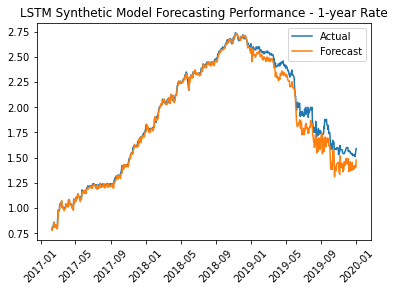

In [32]:
# create dataframe for comparing forecasts to actual
LSTM_synth_compare = pd.concat([pd.DataFrame(yhat_synth), pd.DataFrame(test_y)], axis = 1)
LSTM_synth_compare = pd.concat([date_compare, LSTM_synth_compare], axis = 1)
LSTM_synth_compare.columns = ['date', 'DGS1_pred', 'DGS10_pred', 'DGS1_actual', 'DGS10_actual']

# compute RMSE and MAPE for DGS1
LSTM_synth_rmse = math.sqrt(mean_squared_error(LSTM_synth_compare['DGS1_actual'], LSTM_synth_compare['DGS1_pred']))
LSTM_synth_mape = mean_absolute_percentage_error(LSTM_synth_compare['DGS1_actual'], LSTM_synth_compare['DGS1_pred'])*100
print(f'RMSE: {LSTM_synth_rmse}')
print(f'MAPE: {LSTM_synth_mape}')

# plot results
plt.plot(LSTM_synth_compare['date'], LSTM_synth_compare['DGS1_actual'], label = 'Actual')
plt.plot(LSTM_synth_compare['date'], LSTM_synth_compare['DGS1_pred'], label = 'Forecast')
plt.title('LSTM Synthetic Model Forecasting Performance - 1-year Rate')
plt.legend()
plt.xticks(rotation = 45)
plt.show()